In [5]:
import cv2
import numpy as np
from PIL import Image
from scipy.ndimage import distance_transform_edt as dist_edt
import torch
import torchvision.transforms as transforms

from preprocess.depth_estimation.architecture.model import DPTDepthModel

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "preprocess/depth_estimation/cp/dpt_large-midas-2f21e586.pt"

**DPT depth estimation model loading**

In [7]:

# load depth estimation model. Input needs to be (1, 3, 384, 384)
net = DPTDepthModel(
    path=model_path,
    backbone="vitl16_384",
    non_negative=True,
    enable_attention_hooks=False,
)

net.to(device)
net.eval()

to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

**Image loading**

Original image loading : 

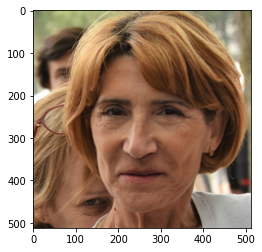

In [8]:
image_org = Image.open("tutorial/tuto_images/depth_estimation/original.png")
image_org = image_org.resize((512, 512), Image.BILINEAR)
image_org_resized = image_org.resize((384, 384), Image.BILINEAR)

plt.imshow(np.asarray(image_org))
plt.show()

Transformed image loading : 

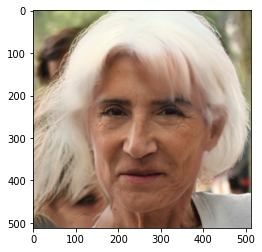

In [9]:
image = Image.open("tutorial/tuto_images/depth_estimation/transformed.png")
image = image.resize((512, 512), Image.BILINEAR)
image_resized = image.resize((384, 384), Image.BILINEAR)

plt.imshow(np.asarray(image))
plt.show()

We can notice in the transformed image above, that the background is not accurate. In particular, the hairs of the woman are merged with the person behind. Beside, the eye of the person behind is not reconstructed. We will remove these artefacts thanks to depth estimation.

**Depth estimation**

Indeed, the idea is to combine the transformed image foreground, and the original image background.

The following function aims to perform depth estimation

In [10]:

def depth_estimation(image, net, device):
    """Compute depth map from image using monocular depth estimation

    Args:
        image (torch.Tensor): image tensor of shape (1, 3, H, W)
        net (torch.nn.Module): depth estimation model
        device (torch.device): device to run the model

    Returns:
        np.array: depth map array of shape (H, W)
    """
    if image.ndim == 3:
        image = torch.unsqueeze(image, 0)
    image = image.to(device)
    net.eval()
    with torch.no_grad():
        pred = net(image)[0]
    pred = pred.cpu().numpy()
    return pred

Depth estimation computing for image and image_org

In [11]:
depth_org = depth_estimation(to_tensor(image_org_resized), net, device)
depth_org = cv2.resize(depth_org, (512, 512),  
                       interpolation = cv2.INTER_NEAREST)

depth = depth_estimation(to_tensor(image_resized), net, device)
depth = cv2.resize(depth, (512, 512),  
                   interpolation = cv2.INTER_NEAREST)

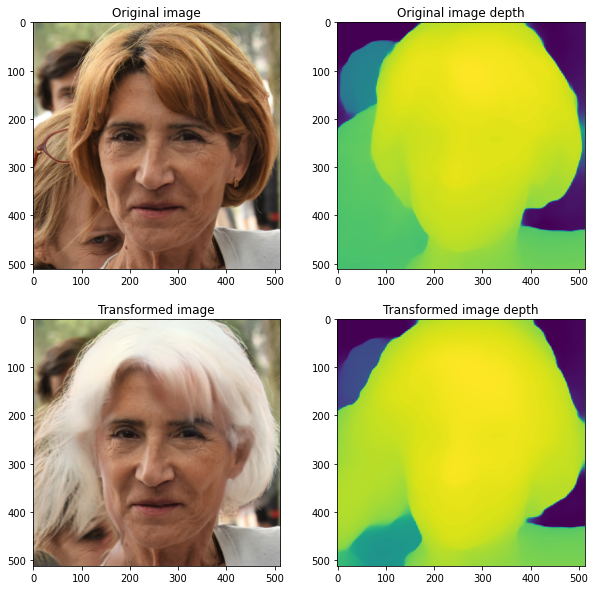

In [12]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(image_org)
plt.title("Original image")
plt.subplot(2, 2, 2)
plt.imshow(depth_org)
plt.title("Original image depth")
plt.subplot(2, 2, 3)
plt.imshow(image)
plt.title("Transformed image")
plt.subplot(2, 2, 4)
plt.imshow(depth)
plt.title("Transformed image depth")
plt.show()

Then, we perform K-means clustering over depth to extract foreground 

In [15]:
def get_foreground_mask(depth):
    """Get foreground pixels from depth map 
    using K-means clustering

    Args:
        depth (np.array): depth map array

    Returns:
        np.array: np.array of shape (n_foreground_pixels, 1) 
                  containing the values of foreground pixels
    """
    Z = depth.flatten().reshape(-1,1)
    km = KMeans(n_clusters=2, random_state=0).fit(Z)
    mask = km.labels_.reshape(depth.shape)
    foreground_values = depth[mask==0].flatten()
    mask[np.where(depth < foreground_values.mean())] = 1
    return 1-mask 

In [16]:
mask_image_org = get_foreground_mask(depth_org)
mask_image = get_foreground_mask(depth)

3D visualization of clustering

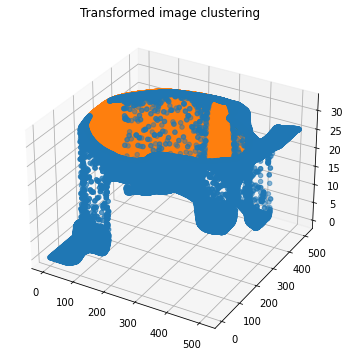

In [17]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
x, y = np.where(mask_image == 0)
ax.scatter3D(x, y,depth[mask_image==0])
x, y = np.where(mask_image == 1)
ax.scatter3D(x, y,depth[mask_image==1])
plt.title("Transformed image clustering")
plt.show()

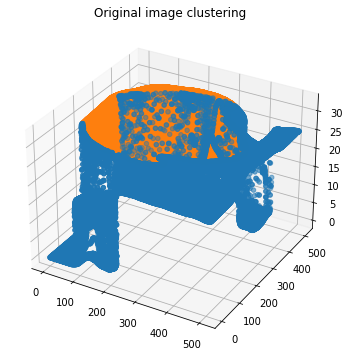

In [18]:

fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
x, y = np.where(mask_image_org == 0)
ax.scatter3D(x, y,depth_org[mask_image_org==0])
x, y = np.where(mask_image_org == 1)
ax.scatter3D(x, y,depth_org[mask_image_org==1])
plt.title("Original image clustering")
plt.show()

Masks visualization of foregrounds

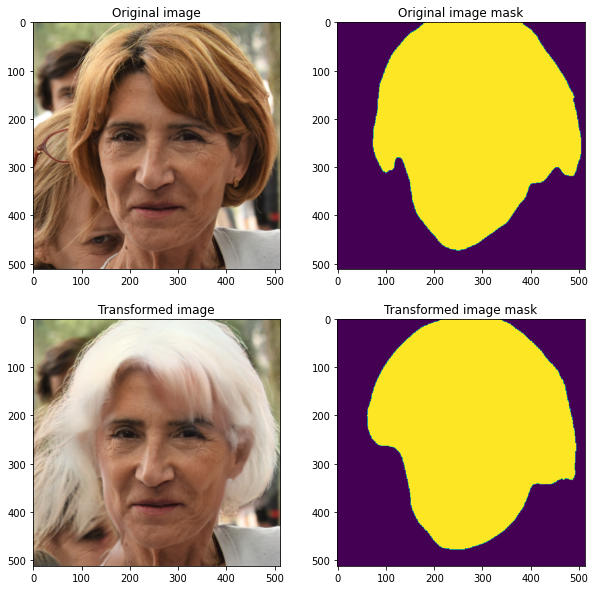

In [19]:

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(image_org)
plt.title("Original image")
plt.subplot(2, 2, 2)
plt.imshow(mask_image_org)
plt.title("Original image mask")
plt.subplot(2, 2, 3)
plt.imshow(image)
plt.title("Transformed image")
plt.subplot(2, 2, 4)
plt.imshow(mask_image)
plt.title("Transformed image mask")
plt.show()

Then we smooth the masks above to perform a smooth merging between image foreground and image_org background

In [21]:
def get_smooth_masks(mask_target, mask_base):   
    if np.sum(mask_target) > np.sum(mask_base): 
        #if the target image has more foreground pixels than the original image
        #take the original image foregroud mask
        mask = mask_base
    else:
        #else take the target image foreground mask
        mask = mask_target

    # smooth foreground mask
    mask_background = dist_edt(1-mask)
    mask_background = mask_background/mask_background.max()
    mask_background = np.multiply(mask_background, 1-mask)
    
    # foreground coefficients
    mask_foreground_smooth = np.exp(-8*mask_background[:,:,None])
    
    #background coefficients
    mask_background_smooth = mask_background[:,:,None]
    
    mask_total = mask_foreground_smooth + mask_background_smooth
    
    # normalized foreground and background coefficients
    mask_foreground_smooth_final = mask_foreground_smooth / mask_total
    mask_background_smooth_final = mask_background_smooth / mask_total

    return mask_foreground_smooth_final, mask_background_smooth_final

In [22]:
mask_foreground_smooth_final,  mask_background_smooth_final = \
    get_smooth_masks(mask_image_org, mask_image)


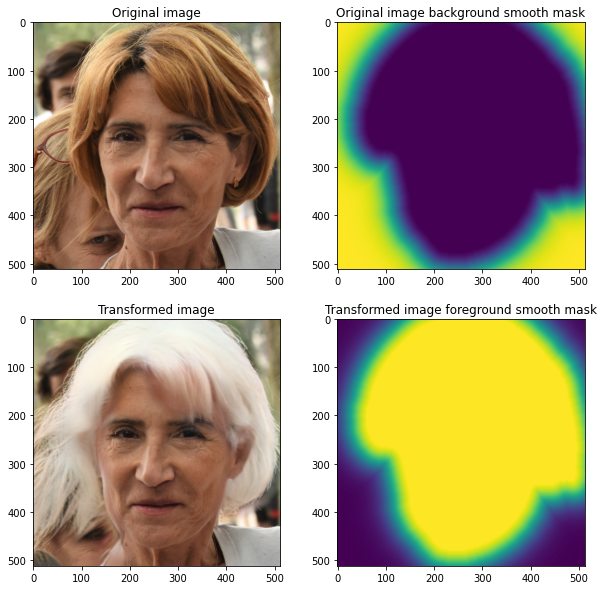

In [23]:

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(image_org)
plt.title("Original image")
plt.subplot(2, 2, 2)
plt.imshow(mask_background_smooth_final)
plt.title("Original image background smooth mask")
plt.subplot(2, 2, 3)
plt.imshow(image)
plt.title("Transformed image")
plt.subplot(2, 2, 4)
plt.imshow(mask_foreground_smooth_final)
plt.title("Transformed image foreground smooth mask")
plt.show()

In fact, we perform target image foreground and original image background mixup, using smooth masks above

In [24]:
def fix_background(depth_org, depth_img, img_org, img):
    """Return target image with base_image background 
    using monocular depth estimation

    Args:
        depth_org (np.array): depth map of original image
        depth (np.array): depth map of target image
        img_org (np.array): original image
        image (np.array): target image       

    Returns:
        np.array: target image with img_org background
    """
    #foreground of the transformed image
    mask_target = get_foreground_mask(depth_img)
    #foreground of the original image
    mask_base = get_foreground_mask(depth_org)
    
    
    mask_foreground_smooth_final, mask_background_smooth_final = \
        get_smooth_masks(mask_target, mask_base)
    
    # take the foreground of image, and the background of the img_org
    image = np.multiply(mask_foreground_smooth_final, img) + \
        np.multiply(mask_background_smooth_final, img_org)
    return image

In [25]:
image_final = fix_background(depth_org, depth, image_org, image)
image_final = Image.fromarray(image_final.astype(np.uint8))

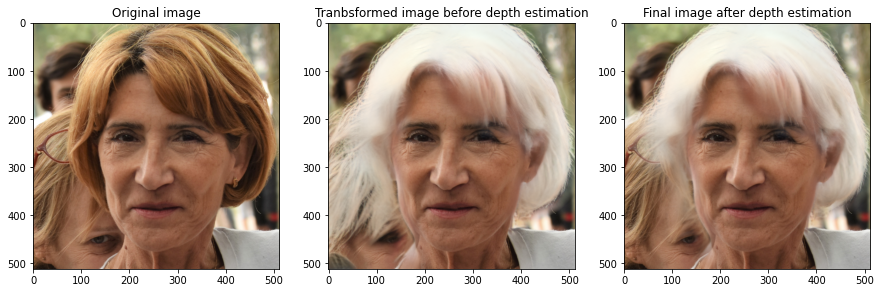

In [26]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(image_org)
plt.title("Original image")
plt.subplot(1, 3, 2)
plt.imshow(image)
plt.title("Tranbsformed image before depth estimation")
plt.subplot(1, 3, 3)
plt.imshow(image_final)
plt.title("Final image after depth estimation")
plt.show()